# Neural Networks

---

The following package is required, please install it.

In [1]:
pip install mongoengine

     |████████████████████████████████| 112kB 3.4MB/s 


---

#####Required imports

Please run the following cells to import all the required packages.

In [2]:
from mongoengine import DictField, StringField, Document, IntField, FloatField, ListField
import matplotlib.pyplot as plt
import numpy as np
from scipy import fftpack

from keras.models import load_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Dense, BatchNormalization, Conv1D, Input, GlobalMaxPooling1D, concatenate, GlobalAveragePooling1D, LSTM
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, mean_squared_error
import seaborn as sns
import pandas as pd


#Only for Google Colaboratory
from google.colab import files

# Camera parameter
FILE_pixel_size = 106 # nm

#####Required physical models, classes and generators.
To test the neural network training, evaluation, and accuracy check, please run the following cells!





######Class NetworkModel 

In [3]:
# MANDATORY, PLEASE RUN!

class NetworkModel(Document):
    track_length = IntField(required=True)
    track_time = FloatField(required=True)
    history = DictField(required=False)
    model_file = StringField(required=False)
    keras_model = None
    net_params = {}
    analysis_params = {}
    meta = {'allow_inheritance': True}

    def __init__(self, *args, **values):
        super().__init__(*args, **values)
        self.model_file = ''.join(['', str(self.id), '.h5'])

    def train_network(self, batch_size):
        pass

    def evaluate_track_input(self, track):
        pass

    def validate_test_data_accuracy(self, n_axes, normalized=True):
        pass

    def validate_test_data_mse(self, n_axes):
        pass

    def convert_history_to_db_format(self, history_training):
        for k, v in history_training.history.items():
            for i in range(len(history_training.history[k])):
                history_training.history[k][i] = float(history_training.history[k][i])
        self.history = history_training.history

    def load_model_from_file(self):
        try:
            self.keras_model = load_model(self.model_file, compile=True)
        except ValueError:
            print("File does not exist!")

    def plot_loss_model(self, train=True, val=True):
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Model Loss')
        if train:
            plt.plot(np.arange(1, len(self.history['loss']) + 1, 1), self.history['loss'], label="Train loss")
        if val:
            plt.plot(np.arange(1, len(self.history['val_loss']) + 1, 1), self.history['val_loss'], label="Val loss")
        plt.legend()
        plt.show()

    def plot_mse_model(self, train=True, val=True):
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Model MSE')
        if train:
            plt.plot(np.arange(1, len(self.history['mse']) + 1, 1), self.history['mse'], label="Train mse")
        if val:
            plt.plot(np.arange(1, len(self.history['val_mse']) + 1, 1), self.history['val_mse'], label="Val mse")
        plt.legend()
        plt.show()

    def plot_accuracy_model(self, train=True, val=True, categorical=False):
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Model Accuracy')
        if categorical:
            if train:
                plt.plot(np.arange(1, len(self.history['categorical_accuracy']) + 1, 1),
                         self.history['categorical_accuracy'], label="Train categorical accuracy")
            if val:
                plt.plot(np.arange(1, len(self.history['val_categorical_accuracy']) + 1, 1),
                         self.history['val_categorical_accuracy'], label="Val categorical accuracy")
        else:
            if train:
                plt.plot(np.arange(1, len(self.history['acc']) + 1, 1), self.history['acc'],
                         label="Train accuracy")
            if val:
                plt.plot(np.arange(1, len(self.history['val_acc']) + 1, 1), self.history['val_acc'],
                         label="Val accuracy")

        plt.legend()
        plt.show()

    def is_valid_network_track_time(self, track_time):
        if (self.track_time * 0.85) <= track_time <= (self.track_time * 1.15):
            return True
        else:
            return False


######Localization error, fBm,Brownian, CTRW and Two-State Diffusion

In [4]:
# MANDATORY, PLEASE RUN!

def add_noise(track_length):
    # New error formula
    mean_error = 40
    sigma_error = 10
    error_x = np.random.normal(loc=mean_error / 2, scale=sigma_error / 2, size=track_length)
    error_x_sign = np.random.choice([-1, 1], size=track_length)
    error_y = np.random.normal(loc=mean_error / 2, scale=sigma_error / 2, size=track_length)
    error_y_sign = np.random.choice([-1, 1], size=track_length)
    return error_x * error_x_sign, error_y * error_y_sign


def add_noise_and_offset(track_length, x, y):
    noise_x, noise_y = add_noise(track_length)
    x_noisy = x + noise_x
    y_noisy = y + noise_y
    if np.min(x_noisy) < np.min(x) and np.min(x_noisy) < 0:
        min_noisy_x = np.absolute(np.min(x_noisy))
        x_noisy = x_noisy + min_noisy_x  # Convert to positive
        x = x + min_noisy_x
    if np.min(x_noisy) > np.min(x) and np.min(x) < 0:
        min_x = np.absolute(np.min(x))
        x_noisy = x_noisy + min_x  # Convert to positive
        x = x + min_x
    if np.min(y_noisy) < np.min(y) and np.min(y_noisy) < 0:
        min_noisy_y = np.absolute(np.min(y_noisy))
        y_noisy = y_noisy + min_noisy_y  # Convert to positive
        y = y + min_noisy_y
    if np.min(y_noisy) > np.min(y) and np.min(y) < 0:
        min_y = np.absolute(np.min(y))
        y_noisy = y_noisy + min_y  # Convert to positive
        y = y + min_y
    offset_x = np.ones(shape=track_length) * np.random.uniform(low=0, high=(
            10000 - np.minimum(np.max(x), np.max(x_noisy))))
    offset_y = np.ones(shape=track_length) * np.random.uniform(low=0, high=(
            10000 - np.minimum(np.max(y), np.max(y_noisy))))
    x = x + offset_x
    y = y + offset_y
    x_noisy = x_noisy + offset_x
    y_noisy = y_noisy + offset_y
    return x, x_noisy, y, y_noisy

class FBM():
    sub_diff_min_max = [0.1, 0.42]
    super_diff_min_max = [0.58, 0.9]

    def __init__(self, hurst_exp):
        self.hurst_exp = hurst_exp

    @classmethod
    def create_random(cls):
        fbm_type = np.random.choice([0,1,2])
        if fbm_type == 0:
            model = cls.create_random_subdiffusive()
        elif fbm_type == 1:
            model = cls.create_random_superdiffusive()
        else:
            model = cls.create_random_brownian()
        return model

    @classmethod
    def create_random_superdiffusive(cls, hurst_exp=None):
        if hurst_exp is not None:
            assert (cls.super_diff_min_max[0] <= hurst_exp <= cls.super_diff_min_max[
                1]), "Invalid Hurst Exponent"
            model = cls(hurst_exp=hurst_exp)

        else:
            random_hurst_exp = np.random.uniform(low=cls.super_diff_min_max[0], high=cls.super_diff_min_max[1])
            model = cls(hurst_exp=random_hurst_exp)
        return model

    @classmethod
    def create_random_subdiffusive(cls, hurst_exp=None):
        if hurst_exp is not None:
            assert (cls.sub_diff_min_max[0] <= hurst_exp <= cls.sub_diff_min_max[
                1]), "Invalid Hurst Exponent"
            model = cls(hurst_exp=hurst_exp)
        else:
            random_hurst_exp = np.random.uniform(low=cls.sub_diff_min_max[0], high=cls.sub_diff_min_max[1])
            model = cls(hurst_exp=random_hurst_exp)
        return model

    @classmethod
    def create_random_brownian(cls, use_exact_exp=False):
        if use_exact_exp:
            model = cls(hurst_exp=0.5)
        else:
            random_brownian_hurst_exp = np.random.uniform(low=cls.sub_diff_min_max[1], high=cls.super_diff_min_max[0])
            model = cls(hurst_exp=random_brownian_hurst_exp)
        return model

    def simulate_track(self, track_length, track_time):

        r = np.zeros(track_length + 1)  # first row of circulant matrix
        r[0] = 1
        idx = np.arange(1, track_length + 1, 1)
        r[idx] = 0.5 * ((idx + 1) ** (2 * self.hurst_exp) - 2 * idx ** (2 * self.hurst_exp) + (idx - 1) ** (
                2 * self.hurst_exp))
        r = np.concatenate((r, r[np.arange(len(r) - 2, 0, -1)]))

        # get eigenvalues through fourier transform
        lamda = np.real(fftpack.fft(r)) / (2 * track_length)

        # get trajectory using fft: dimensions assumed uncoupled
        x = fftpack.fft(np.sqrt(lamda) * (
                np.random.normal(size=(2 * track_length)) + 1j * np.random.normal(size=(2 * track_length))))
        x = track_length ** (-self.hurst_exp) * np.cumsum(np.real(x[:track_length]))  # rescale
        x = ((track_time ** self.hurst_exp) * x)  # resulting trajectory in x

        y = fftpack.fft(np.sqrt(lamda) * (
                np.random.normal(size=(2 * track_length)) + 1j * np.random.normal(size=(2 * track_length))))
        y = track_length ** (-self.hurst_exp) * np.cumsum(np.real(y[:track_length]))  # rescale
        y = ((track_time ** self.hurst_exp) * y)  # resulting trajectory in y

        # Scale to 10.000 nm * 10.000 nm
        if np.min(x) < 0:
            x = x + np.absolute(np.min(x))  # Add offset to x
        if np.min(y) < 0:
            y = y + np.absolute(np.min(y))  # Add offset to y

        # Scale to nm and add a random offset
        x = x * FILE_pixel_size
        y = y * FILE_pixel_size

        x, x_noisy, y, y_noisy = add_noise_and_offset(track_length, x, y)

        t = np.linspace(0, track_time, track_length)

        return x_noisy, y_noisy, x, y, t

    def get_diffusion_type(self):
        if self.sub_diff_min_max[0] <= self.hurst_exp <= self.sub_diff_min_max[1]:
            return "Subdiffusive"
        elif self.sub_diff_min_max[1] < self.hurst_exp < self.super_diff_min_max[0]:
            return "Brownian"
        else:
            return "Superdiffusive"

        

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


class CTRW():
    min_alpha = 0.1
    max_alpha = 0.9

    def __init__(self, alpha):
        assert (self.min_alpha <= alpha <= self.max_alpha), "Invalid alpha parameter"
        self.alpha = alpha
        self.beta = 0.5
        self.gamma = 1

    @classmethod
    def create_random(cls):
        random_alpha = np.random.uniform(low=cls.min_alpha, high=cls.max_alpha)
        model = cls(alpha=random_alpha)
        return model

    def mittag_leffler_rand(self, track_length):
        # Generate mittag-leffler random numbers
        t = -np.log(np.random.uniform(size=[track_length, 1]))
        u = np.random.uniform(size=[track_length, 1])
        w = np.sin(self.beta * np.pi) / np.tan(self.beta * np.pi * u) - np.cos(self.beta * np.pi)
        t = t * (w ** 1 / self.beta)
        t = self.gamma * t
        return t

    def symmetric_alpha_levy(self, track_length):
        alpha_levy_dist = 2
        gamma_levy_dist = self.gamma ** (self.alpha / 2)
        # Generate symmetric alpha-levi random numbers
        u = np.random.uniform(size=[track_length, 1])
        v = np.random.uniform(size=[track_length, 1])

        phi = np.pi * (v - 0.5)
        w = np.sin(alpha_levy_dist * phi) / np.cos(phi)
        z = -1 * np.log(u) * np.cos(phi)
        z = z / np.cos((1 - alpha_levy_dist) * phi)
        x = gamma_levy_dist * w * z ** (1 - (1 / alpha_levy_dist))

        return x

    def simulate_track(self, track_length, track_time):

        jumps_x = self.mittag_leffler_rand(track_length)
        raw_time_x = np.cumsum(jumps_x)
        t_x = raw_time_x * track_time / np.max(raw_time_x)
        t_x = np.reshape(t_x, [len(t_x), 1])

        jumps_y = self.mittag_leffler_rand(track_length)
        raw_time_y = np.cumsum(jumps_y)
        t_y = raw_time_y * track_time / np.max(raw_time_y)
        t_y = np.reshape(t_y, [len(t_y), 1])

        x = self.symmetric_alpha_levy(track_length)
        x = np.cumsum(x)
        x = np.reshape(x, [len(x), 1])

        y = self.symmetric_alpha_levy(track_length)
        y = np.cumsum(y)
        y = np.reshape(y, [len(y), 1])

        t_out = np.arange(0, track_length, 1) * track_time / track_length
        x_out = np.zeros([track_length, 1])
        y_out = np.zeros([track_length, 1])
        for i in range(track_length):
            x_out[i, 0] = x[find_nearest(t_x, t_out[i]), 0]
            y_out[i, 0] = y[find_nearest(t_y, t_out[i]), 0]

        x = x_out[:, 0]
        y = y_out[:, 0]
        t = t_out

        # Scale to 10.000 nm * 10.000 nm
        if np.min(x) < 0:
            x = x + np.absolute(np.min(x))  # Add offset to x
        if np.min(y) < 0:
            y = y + np.absolute(np.min(y))  # Add offset to y
        # Scale to nm and add a random offset
        x = x * FILE_pixel_size / 10
        y = y * FILE_pixel_size / 10

        x, x_noisy, y, y_noisy = add_noise_and_offset(track_length, x, y)

        return x_noisy, y_noisy, x, y, t

    
class TwoStateObstructedDiffusion():
    """
    State-0: Free Diffusion
    State-1: Obstructed Diffusion
    """
    d0_low = 0.05
    d0_high = 0.2
    k0_low = 0.01
    k0_high = 0.08
    k1_low = 0.007
    k1_high = 0.2

    def __init__(self, k_state0, k_state1, d_state0):
        self.k_state0 = k_state0
        self.k_state1 = k_state1
        self.D_state0 = d_state0 * 1000000  # Convert from um^2 -> nm^2

    @classmethod
    def create_random(cls):
        # k_state(i) dimensions = 1 / frame
        # D_state(i) dimensions = um^2 * s^(-beta)
        d_state0 = np.random.uniform(low=cls.d0_low, high=cls.d0_high)
        k_state0 = np.random.uniform(low=cls.k0_low, high=cls.k0_high)
        k_state1 = np.random.uniform(low=cls.k1_low, high=cls.k1_high)
        model = cls(k_state0, k_state1, d_state0)
        return model

    @classmethod
    def create_with_coefficients(cls, k_state0, k_state1, d_state0):
        assert (d_state0 > 0), "Invalid Diffusion coefficient state-0"
        assert (k_state0 > 0), "Invalid switching rate state-0"
        assert (k_state0 > 0), "Invalid switching rate state-1"
        return cls(k_state0, k_state1, d_state0)

    def get_d_state0(self):
        return self.D_state0 / 1000000

    def normalize_d_coefficient_to_net(self, state_number):
        assert (state_number == 0), "Not a valid state"
        delta_d0 = self.d0_high - self.d0_low
        return (1 / delta_d0) * (self.get_d_state0() - self.d0_low)

    @classmethod
    def denormalize_d_coefficient_to_net(cls, output_coefficient_net):
        delta_d0 = cls.d0_high - cls.d0_low
        return output_coefficient_net * delta_d0 + cls.d0_low

    def simulate_track(self, track_length, track_time):
        x = np.zeros(shape=track_length)
        y = np.zeros(shape=track_length)

        state, switching = self.simulate_switching_states(track_length)

        if state[0] == 1:
            x[0] = np.random.normal(loc=0, scale=5)
            y[0] = np.random.normal(loc=0, scale=5)
        else:
            x[0] = np.random.normal(loc=0, scale=1)
            y[0] = np.random.normal(loc=0, scale=1)

        i = 1
        while i < track_length:
            while state[i] == 0 and i < track_length:
                jumps_x = np.random.normal(loc=0, scale=1)
                jumps_y = np.random.normal(loc=0, scale=1)
                x[i] = x[i - 1] + (jumps_x * np.sqrt(2 * self.D_state0 * (track_time / track_length)))
                y[i] = y[i - 1] + (jumps_y * np.sqrt(2 * self.D_state0 * (track_time / track_length)))
                i += 1
                if i >= track_length:
                    break

            confinement_flag = True
            if i >= track_length:
                break
            while state[i] == 1 and i < track_length:
                if confinement_flag:
                    confinement_region_min_x, confinement_region_max_x = self.simulate_confinement_region(x[i - 1])
                    confinement_region_min_y, confinement_region_max_y = self.simulate_confinement_region(y[i - 1])
                    confinement_flag = False

                jumps_x = np.random.normal(loc=0, scale=5)
                jumps_y = np.random.normal(loc=0, scale=5)

                if jumps_x > 0:
                    if x[i - 1] + jumps_x > confinement_region_max_x:
                        x[i] = x[i - 1]
                    else:
                        x[i] = x[i - 1] + jumps_x
                else:
                    if x[i - 1] + jumps_x < confinement_region_min_x:
                        x[i] = x[i - 1]
                    else:
                        x[i] = x[i - 1] + jumps_x

                if jumps_y > 0:
                    if y[i - 1] + jumps_y > confinement_region_max_y:
                        y[i] = y[i - 1]
                    else:
                        y[i] = y[i - 1] + jumps_y

                else:
                    if y[i - 1] + jumps_y < confinement_region_min_y:
                        y[i] = y[i - 1]
                    else:
                        y[i] = y[i - 1] + jumps_y

                i += 1
                if i >= track_length:
                    break

        x, x_noisy, y, y_noisy = add_noise_and_offset(track_length, x, y)

        t = self.simulate_tract_time(track_length, track_time)

        return x_noisy, y_noisy, x, y, t, state, switching

    def simulate_track_only_state0(self, track_length, track_time):
        x = np.random.normal(loc=0, scale=1, size=track_length)
        y = np.random.normal(loc=0, scale=1, size=track_length)

        for i in range(track_length):
            x[i] = x[i] * np.sqrt(2 * self.D_state0 * (track_time / track_length))
            y[i] = y[i] * np.sqrt(2 * self.D_state0 * (track_time / track_length))

        x = np.cumsum(x)
        y = np.cumsum(y)

        x, x_noisy, y, y_noisy = add_noise_and_offset(track_length, x, y)

        t = self.simulate_tract_time(track_length, track_time)

        return x_noisy, y_noisy, x, y, t

    def simulate_track_only_state1(self, track_length, track_time):
        initial_pos_x = np.random.normal(loc=0, scale=5)
        initial_pos_y = np.random.normal(loc=0, scale=5)

        confinement_region_min_x, confinement_region_max_x = self.simulate_confinement_region(initial_pos_x)
        confinement_region_min_y, confinement_region_max_y = self.simulate_confinement_region(initial_pos_y)

        x = np.zeros(shape=track_length)
        y = np.zeros(shape=track_length)

        jumps_x = np.random.normal(loc=0, scale=5, size=track_length)
        jumps_y = np.random.normal(loc=0, scale=5, size=track_length)

        x[0], y[0] = initial_pos_x, initial_pos_y

        for i in range(1, track_length):
            if jumps_x[i] > 0:
                if x[i - 1] + jumps_x[i] > confinement_region_max_x:
                    x[i] = x[i - 1]
                else:
                    x[i] = x[i - 1] + jumps_x[i]

            else:
                if x[i - 1] + jumps_x[i] < confinement_region_min_x:
                    x[i] = x[i - 1]
                else:
                    x[i] = x[i - 1] + jumps_x[i]

            if jumps_y[i] > 0:
                if y[i - 1] + jumps_y[i] > confinement_region_max_y:
                    y[i] = y[i - 1]
                else:
                    y[i] = y[i - 1] + jumps_y[i]

            else:
                if y[i - 1] + jumps_y[i] < confinement_region_min_y:
                    y[i] = y[i - 1]
                else:
                    y[i] = y[i - 1] + jumps_y[i]

        x, x_noisy, y, y_noisy = add_noise_and_offset(track_length, x, y)

        t = self.simulate_tract_time(track_length, track_time)

        return x_noisy, y_noisy, x, y, t

    def simulate_tract_time(self, track_length, track_time):
        t = np.linspace(0, track_time, track_length)
        return t

    def simulate_confinement_region(self, initial_pos):
        confinement_region_size = np.random.uniform(low=20, high=40)
        offset_region = initial_pos + np.random.uniform(low=(-confinement_region_size / 2),
                                                        high=(confinement_region_size / 2))

        confinement_region_max = offset_region + (confinement_region_size / 2)
        confinement_region_min = offset_region - (confinement_region_size / 2)

        return confinement_region_min, confinement_region_max

    def simulate_switching_states(self, track_length):
        # Residence time
        res_time0 = 1 / self.k_state0
        res_time1 = 1 / self.k_state1

        # Compute each t_state according to exponential laws
        t_state0 = np.random.exponential(scale=res_time0, size=track_length)
        t_state1 = np.random.exponential(scale=res_time1, size=track_length)

        # Set initial t_state for each state
        t_state0_next = 0
        t_state1_next = 0

        # Pick an initial state from a random choice
        current_state = np.random.choice([0, 1])

        # Detect real switching behavior
        switching = ((current_state == 0) and (int(np.ceil(t_state0[t_state0_next])) < track_length)) or (
                (current_state == 1) and (int(np.ceil(t_state1[t_state1_next])) < track_length))

        # Fill state array
        state = np.zeros(shape=track_length)
        i = 0

        while i < track_length:
            if current_state == 1:
                current_state_length = int(np.ceil(t_state1[t_state1_next]))

                if (current_state_length + i) < track_length:
                    state[i:(i + current_state_length)] = np.ones(shape=current_state_length)
                else:
                    state[i:track_length] = np.ones(shape=(track_length - i))

                current_state = 0  # Set state from 1->0
            else:
                current_state_length = int(np.ceil(t_state0[t_state0_next]))
                current_state = 1  # Set state from 0->1

            i += current_state_length

        return state, switching

class Brownian():

    # d_high = 0.6
    # d_low = 0.003

    d_high = 0.2
    d_low = 0.05

    def __init__(self, diffusion_coefficient):
        self.d_coef = diffusion_coefficient

    @classmethod
    def create_random(cls):
        diffusion_coefficient = np.random.uniform(low=cls.d_low, high=cls.d_high)
        return cls(diffusion_coefficient=diffusion_coefficient)

    def simulate_track(self, track_length, track_time):
        x = np.random.normal(loc=0, scale=1, size=track_length)
        y = np.random.normal(loc=0, scale=1, size=track_length)

        for i in range(track_length):
            x[i] = x[i] * np.sqrt(2 * self.d_coef * (track_time / track_length))
            y[i] = y[i] * np.sqrt(2 * self.d_coef * (track_time / track_length))

        x = np.cumsum(x)
        y = np.cumsum(y)

        x, x_noisy, y, y_noisy = add_noise_and_offset(track_length, x, y)

        t = np.linspace(0, track_time, track_length)

        return x_noisy, y_noisy, x, y, t

    def normalize_d_coefficient_to_net(self):
        delta_d = self.d_high - self.d_low
        return (1 / delta_d) * (self.d_coef - self.d_low)

    @classmethod
    def denormalize_d_coefficient_to_net(cls, output_coefficient_net):
        delta_d = cls.d_high - cls.d_low
        return output_coefficient_net * delta_d + cls.d_low

    def get_d_coefficient(self):
        return self.d_coef


######Class Tracks

In [5]:
# MANDATORY, PLEASE RUN!

class Tracks(Document):
    track_length = IntField(min_value=1, required=True)
    track_time = FloatField(min_value=0, required=True)
    n_axes = IntField(min_value=1, required=True)
    time_axis = ListField(required=True)
    axes_data = DictField(required=True)

    meta = {'allow_inheritance': True}

    def plot_xy(self):
        assert (self.n_axes >= 2), "Track n_axes < 2!"
        plt.xlabel("Position X [nm]")
        plt.ylabel("Position Y [nm]")
        plt.plot(self.axes_data['0'], self.axes_data['1'])
        plt.show()

    def plot_axis_with_time(self, n_axis):
        assert (self.n_axes >= n_axis > 0), "Invalid axis"
        plt.xlabel("Time")
        plt.ylabel(f"Axis {n_axis - 1}")
        plt.plot(self.time_axis, self.axes_data[str(n_axis - 1)])
        plt.show()

    def plot_axis_velocity(self, n_axes):
        assert (self.n_axes >= n_axes > 0), "Invalid axis"
        plt.xlabel("Time")
        plt.ylabel(f"Velocity Axis {n_axes - 1}")
        dt = self.time_axis[1] - self.time_axis[0]
        velocity_axis = np.diff(np.asarray(self.axes_data[str(n_axes-1)])) * (1 / dt)
        plt.plot(self.time_axis[:len(self.time_axis) - 1], velocity_axis)
        plt.show()

    def set_axes_data(self, axes_data):
        for i in range(self.n_axes):
            axis_data = axes_data[i].tolist()
            assert len(axis_data) == self.track_length
            self.axes_data[str(i)] = axis_data

    def set_time_axis(self, time_axis_data):
        time_axis_data = time_axis_data.tolist()
        assert (len(time_axis_data) == self.track_length)
        self.time_axis = time_axis_data

class SimulatedTrack(Tracks):
    model_type = StringField(required=True)

######Generator classification network

In [6]:
# MANDATORY, PLEASE RUN!

def axis_adaptation_to_net(axis_data, track_length):
    axis_reshaped = np.reshape(axis_data, newshape=[1, len(axis_data)])
    axis_reshaped = axis_reshaped - np.mean(axis_reshaped)
    axis_diff = np.diff(axis_reshaped[0, :track_length])
    return axis_diff


def generate_batch_of_samples_l1(batch_size, track_length, track_time):
    out = np.zeros(shape=[batch_size, track_length - 1, 2])
    label = np.zeros(shape=[batch_size, 1])
    t_sample = np.random.choice(np.linspace(track_time * 0.85, track_time * 1.15, 50))
    track_length_sample = int(np.random.choice(np.arange(track_length, np.ceil(track_length * 1.05), 1)))

    for i in range(batch_size):
        physical_model_type = np.random.choice(["fbm", "ctrw", "two-state"])
        if physical_model_type == "fbm":
            physical_model = FBM.create_random()
            x_noisy, y_noisy, x, y, t = physical_model.simulate_track(track_length=track_length_sample,
                                                                      track_time=t_sample)
            label[i, 0] = 0
        elif physical_model_type == "ctrw":
            physical_model = CTRW.create_random()
            x_noisy, y_noisy, x, y, t = physical_model.simulate_track(track_length=track_length_sample,
                                                                      track_time=t_sample)
            label[i, 0] = 1
        else:
            physical_model = TwoStateObstructedDiffusion.create_random()
            switching = False
            while not switching:
                x_noisy, y_noisy, x, y, t, state, switching = physical_model.simulate_track(
                    track_length=track_length_sample,
                    track_time=t_sample)
            label[i, 0] = 2

        out[i, :, 0] = axis_adaptation_to_net(axis_data=x_noisy, track_length=track_length)
        out[i, :, 1] = axis_adaptation_to_net(axis_data=y_noisy, track_length=track_length)

    return out, label


def generator_first_layer(batch_size, track_length, track_time):
    while True:
        out, label = generate_batch_of_samples_l1(batch_size=batch_size,
                                                  track_length=track_length,
                                                  track_time=track_time)
        label = to_categorical(y=label, num_classes=3)
        input_net = np.zeros(shape=[batch_size, track_length - 1, 1])

        for i in range(batch_size):
            input_net[i, :, 0] = out[i, :, 0]

        yield input_net, label
        
def plot_confusion_matrix_for_layer(layer_name, ground_truth, predicted_value, labels, normalized):
    # Create df with confusion matrix
    confusion_mat = confusion_matrix(y_true=ground_truth, y_pred=predicted_value)
    if normalized:
        confusion_mat = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]

    df_cm = pd.DataFrame(data=confusion_mat, index=labels, columns=labels)
    sns.set(font_scale=1)
    color_map = sns.color_palette(palette="Blues", n_colors=7)
    sns.heatmap(data=df_cm, annot=True, annot_kws={"size": 12}, cmap=color_map)
    # Plot matrix
    plt.title(f'Confusion Matrix {layer_name}')
    plt.ylabel("Ground Truth")
    plt.xlabel("Predicted")
    plt.show()

######Generator fBm classification network

In [7]:
def generator_second_layer(batch_size, track_length, track_time):
    while True:
        out, label = generate_batch_of_samples_l2(batch_size=batch_size,
                                                  track_length=track_length,
                                                  track_time=track_time)
        label = to_categorical(y=label, num_classes=3)
        input_net = np.zeros(shape=[batch_size, track_length - 1, 1])
        for i in range(batch_size):
            input_net[i, :, 0] = out[i, :, 0]
        yield input_net, label


def generate_batch_of_samples_l2(batch_size, track_length, track_time):
    out = np.zeros(shape=[batch_size, track_length - 1, 2])
    label = np.zeros(shape=[batch_size, 1])
    t_sample = np.random.choice(np.linspace(track_time * 0.85, track_time * 1.15, 50))
    track_length_sample = int(np.random.choice(np.arange(track_length, np.ceil(track_length * 1.05), 1)))

    for i in range(batch_size):
        model_sample = np.random.choice(["sub", "brownian", "super"])
        if model_sample == "sub":
            model = FBM.create_random_subdiffusive()
            label[i, 0] = 0

        elif model_sample == "brownian":
            model = FBM.create_random_brownian()
            label[i, 0] = 1

        else:
            model = FBM.create_random_superdiffusive()
            label[i, 0] = 2

        x_noisy, y_noisy, x, y, t = model.simulate_track(track_length=track_length_sample, track_time=t_sample)

        out[i, :, 0] = axis_adaptation_to_net(axis_data=x_noisy, track_length=track_length)
        out[i, :, 1] = axis_adaptation_to_net(axis_data=y_noisy, track_length=track_length)

    return out, label


######Generator segmentation network



In [8]:
def generate_batch_of_samples_state_net(batch_size, track_length, track_time):
    out = np.zeros(shape=[batch_size, track_length, 2])
    label = np.zeros(shape=[batch_size, track_length])
    t_sample = np.random.choice(np.linspace(track_time * 0.85, track_time * 1.15, 50))
    track_length_sample = int(np.random.choice(np.arange(track_length, np.ceil(track_length * 1.05), 1)))

    for i in range(batch_size):
        model = TwoStateObstructedDiffusion.create_random()
        switching = False
        while not switching:
            x_noisy, y_noisy, x, y, t, state, switching = model.simulate_track(track_length=track_length_sample,
                                                                               track_time=t_sample)

        axis_reshaped = np.reshape(x_noisy, [1, len(x_noisy)])[:, :track_length]
        out[i, :, 0] = axis_reshaped - np.mean(axis_reshaped)

        axis_reshaped = np.reshape(y_noisy, [1, len(y_noisy)])[:, :track_length]
        out[i, :, 1] = axis_reshaped - np.mean(axis_reshaped)

        label[i, :] = state[:track_length]

    return out, label


def generator_state_net(batch_size, track_length, track_time):
    while True:
        out, label = generate_batch_of_samples_state_net(batch_size=batch_size,
                                                         track_length=track_length,
                                                         track_time=track_time)

        input_net = np.zeros(shape=[batch_size, track_length, 1])
        for i in range(batch_size):
            input_net[i, :, 0] = out[i, :, 0]

        yield input_net, label


######Generator hurst network

In [9]:
def generator_hurst_exp_network(batch_size, track_length, track_time, fbm_type):
    while True:
        out = np.zeros(shape=(batch_size, 2, track_length))
        label = np.zeros(shape=(batch_size, 1))
        t_sample = np.random.choice(np.linspace(track_time * 0.85, track_time * 1.15, 50))
        for i in range(batch_size):
            if fbm_type == 'Subdiffusive':
                model_sample = FBM.create_random_subdiffusive()
            elif fbm_type == 'Brownian':
                model_sample = FBM.create_random_brownian()
            else:
                model_sample = FBM.create_random_superdiffusive()

            x_noisy, y_nosy, x, y, t = model_sample.simulate_track(track_length=track_length, track_time=t_sample)
            label[i, 0] = model_sample.hurst_exp

            zero_mean_x = x_noisy - np.mean(x_noisy)
            zero_mean_x = zero_mean_x / np.std(zero_mean_x)
            out[i, 0, :] = zero_mean_x
            out[i, 1, :] = np.linspace(0, 1, track_length)

        yield out, label


######Generator diffusion coefficient network

In [10]:
def generator_diffusion_coefficient_network(batch_size, track_length, track_time, diffusion_model_range):
    while True:
        t_sample = np.random.choice(np.linspace(track_time * 0.85, track_time * 1.15, 50))
        out = np.zeros(shape=[batch_size, 2, 1])
        label = np.zeros(shape=[batch_size, 1])
        noisy_out = np.zeros(shape=[batch_size, track_length])
        m_noisy_out = np.zeros(shape=batch_size)

        for i in range(batch_size):

            if diffusion_model_range == "2-State-OD":
                model = TwoStateObstructedDiffusion.create_random()
                x_noisy, y_noisy, x, y, t = model.simulate_track_only_state0(track_length=track_length,
                                                                             track_time=t_sample)
                label[i, 0] = model.normalize_d_coefficient_to_net(state_number=0)
            else:
                model = Brownian.create_random()
                x_noisy, y_noisy, x, y, t = model.simulate_track(track_length=track_length, track_time=track_time)
                label[i, 0] = model.normalize_d_coefficient_to_net()

            m_noisy_out[i] = np.mean(x_noisy)
            noisy_out[i, :] = x_noisy - m_noisy_out[i]

        noise_reduced_x = noisy_out

        dx = np.diff(noise_reduced_x, axis=1)
        m = np.mean(np.abs(dx), axis=1)
        s = np.std(dx, axis=1)

        for i in range(batch_size):
            out[i, :, 0] = [m[i], s[i]]

        yield out, label

---
## Classification Network 
##### Output Categories  
* fBm 
* CTRW
* 2-State-OD

######Network implementation

In [ ]:
class L1NetworkModel(NetworkModel):
    output_categories = 3
    output_categories_labels = ["fBm", "CTRW", "2-State-OD"]
    model_name = 'L1 Network'
    net_params = {
        'initializer': 'he_normal',
        'filters_size': 32,
        'x1_kernel': 4,
        'x2_kernel': 2,
        'x3_kernel': 3,
        'x4_kernel': 10,
        'x5_kernel': 20,
        'lr': 1e-4,
        'dense1_units': 512,
        'dense2_units': 128,
        'batch_size': 8
    }
    # For analysis of hyper-params
    analysis_params = {}

    def train_network(self, batch_size):
        initializer = self.net_params['initializer']
        filters = self.net_params['filters_size']
        x1_kernel = self.net_params['x1_kernel']
        x2_kernel = self.net_params['x2_kernel']
        x3_kernel = self.net_params['x3_kernel']
        x4_kernel = self.net_params['x4_kernel']
        x5_kernel = self.net_params['x5_kernel']

        inputs = Input(shape=(self.track_length - 1, 1))

        x1 = Conv1D(filters=filters, kernel_size=x1_kernel, padding='causal', activation='relu',
                    kernel_initializer=initializer)(inputs)
        x1 = BatchNormalization()(x1)
        x1 = Conv1D(filters=filters, kernel_size=x1_kernel, dilation_rate=2, padding='causal',
                    activation='relu',
                    kernel_initializer=initializer)(x1)
        x1 = BatchNormalization()(x1)
        x1 = Conv1D(filters=filters, kernel_size=x1_kernel, dilation_rate=4, padding='causal',
                    activation='relu',
                    kernel_initializer=initializer)(x1)
        x1 = BatchNormalization()(x1)
        x1 = GlobalMaxPooling1D()(x1)

        x2 = Conv1D(filters=filters, kernel_size=x2_kernel, padding='causal', activation='relu',
                    kernel_initializer=initializer)(inputs)
        x2 = BatchNormalization()(x2)
        x2 = Conv1D(filters=filters, kernel_size=x2_kernel, dilation_rate=2, padding='causal',
                    activation='relu',
                    kernel_initializer=initializer)(x2)
        x2 = BatchNormalization()(x2)
        x2 = Conv1D(filters=filters, kernel_size=x2_kernel, dilation_rate=4, padding='causal',
                    activation='relu',
                    kernel_initializer=initializer)(x2)
        x2 = BatchNormalization()(x2)
        x2 = GlobalMaxPooling1D()(x2)

        x3 = Conv1D(filters=filters, kernel_size=x3_kernel, padding='causal', activation='relu',
                    kernel_initializer=initializer)(inputs)
        x3 = BatchNormalization()(x3)
        x3 = Conv1D(filters=filters, kernel_size=x3_kernel, dilation_rate=2, padding='causal',
                    activation='relu',
                    kernel_initializer=initializer)(x3)
        x3 = BatchNormalization()(x3)
        x3 = Conv1D(filters=filters, kernel_size=x3_kernel, dilation_rate=4, padding='causal',
                    activation='relu',
                    kernel_initializer=initializer)(x3)
        x3 = BatchNormalization()(x3)
        x3 = GlobalMaxPooling1D()(x3)

        x4 = Conv1D(filters=filters, kernel_size=x4_kernel, padding='causal', activation='relu',
                    kernel_initializer=initializer)(inputs)
        x4 = BatchNormalization()(x4)
        x4 = Conv1D(filters=filters, kernel_size=x4_kernel, dilation_rate=4, padding='causal',
                    activation='relu',
                    kernel_initializer=initializer)(x4)
        x4 = BatchNormalization()(x4)
        x4 = Conv1D(filters=filters, kernel_size=x4_kernel, dilation_rate=8, padding='causal',
                    activation='relu',
                    kernel_initializer=initializer)(x4)
        x4 = BatchNormalization()(x4)
        x4 = GlobalMaxPooling1D()(x4)

        x5 = Conv1D(filters=filters, kernel_size=x5_kernel, padding='same', activation='relu',
                    kernel_initializer=initializer)(inputs)
        x5 = BatchNormalization()(x5)
        x5 = GlobalMaxPooling1D()(x5)

        x_concat = concatenate(inputs=[x1, x2, x3, x4, x5])

        dense_1 = Dense(units=self.net_params['dense1_units'], activation='relu')(x_concat)
        dense_2 = Dense(units=self.net_params['dense2_units'], activation='relu')(dense_1)
        output_network = Dense(units=self.output_categories, activation='softmax')(dense_2)
        l1_keras_model = Model(inputs=inputs, outputs=output_network)

        optimizer = Adam(lr=self.net_params['lr'])
        l1_keras_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        l1_keras_model.summary()

        callbacks = [ModelCheckpoint(filepath="{}.h5".format(self.id),
                                     monitor='val_categorical_accuracy',
                                     verbose=1,
                                     save_best_only=True)]

        history_training = l1_keras_model.fit(x=generator_first_layer(batch_size=batch_size,
                                                                      track_length=self.track_length,
                                                                      track_time=self.track_time),
                                              steps_per_epoch=2400,
                                              epochs=50,
                                              callbacks=callbacks,
                                              validation_data=generator_first_layer(batch_size=batch_size,
                                                                                    track_length=self.track_length,
                                                                                    track_time=self.track_time),
                                              validation_steps=200)

        self.convert_history_to_db_format(history_training)
        self.keras_model = l1_keras_model

    def evaluate_track_input(self, track):
        assert (track.track_length == self.track_length), "Invalid input track length"

        model_predictions = np.zeros(shape=self.output_categories)

        axis_data_diff = np.zeros(shape=[1, self.track_length - 1, track.n_axes])
        for i in range(track.n_axes):
            axis_data_diff[0, :, i] = axis_adaptation_to_net(axis_data=track.axes_data[str(i)],
                                                             track_length=self.track_length)

        for axis in range(track.n_axes):
            input_net = np.zeros([1, self.track_length - 1, 1])
            input_net[0, :, 0] = axis_data_diff[0, :, axis]
            model_predictions = (self.keras_model.predict(input_net)[0, :]) + model_predictions
        mean_prediction = np.argmax(model_predictions / track.n_axes)
        return mean_prediction

    def validate_test_data_accuracy(self, n_axes, normalized=True):
        test_batch_size = 100
        ground_truth = np.zeros(shape=test_batch_size)
        predicted_value = np.zeros(shape=test_batch_size)
        for i in range(test_batch_size):
            ground_truth[i] = np.random.choice([0, 1, 2])
            if ground_truth[i] == 0:
                physical_model = FBM.create_random()
            elif ground_truth[i] == 1:
                physical_model = CTRW.create_random()
            else:
                physical_model = TwoStateObstructedDiffusion.create_random()

            if ground_truth[i] < 2:
                x_noisy, y_noisy, x, y, t = physical_model.simulate_track(self.track_length, self.track_time)
            else:
                x_noisy, y_noisy, x, y, t, state, switching = physical_model.simulate_track(self.track_length,
                                                                                            self.track_time)

            track = SimulatedTrack(track_length=self.track_length, track_time=self.track_time,
                                   n_axes=n_axes, model_type=physical_model.__class__.__name__)
            track.set_axes_data([x_noisy, y_noisy])
            track.set_time_axis(t)

            predicted_value[i] = self.evaluate_track_input(track=track)

        plot_confusion_matrix_for_layer(layer_name=self.model_name,
                                        ground_truth=ground_truth,
                                        predicted_value=predicted_value,
                                        labels=self.output_categories_labels,
                                        normalized=normalized)

    def output_net_to_labels(self, output_net):
        return self.output_categories_labels[output_net]


######Network training

In [ ]:
track_length = 25
track_time = 0.5


# Train network
K.clear_session()
model_l1 = L1NetworkModel(track_length=track_length, track_time=track_time)
model_l1.train_network(batch_size=8)



Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 1)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 24, 32)       160         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 24, 32)       96          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 24, 32)       128         input_1[0][0]                    
_______________________________________________________________________________________

######Load a pre-trained model

In [ ]:
#Run this cell to upload the model, then add the filename to the following cell
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
pre_trained_model = L1NetworkModel()
pre_trained_model.model_file = '' # Here replace with the filename!
pre_trained_model.load_model_from_file()
model_l1 = pre_trained_model

######Network accuracy

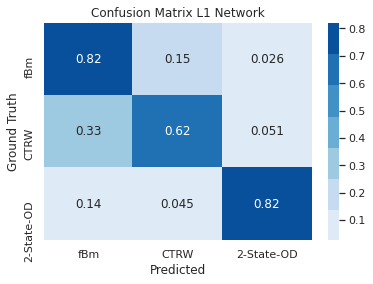

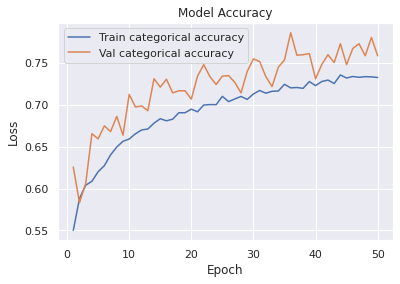

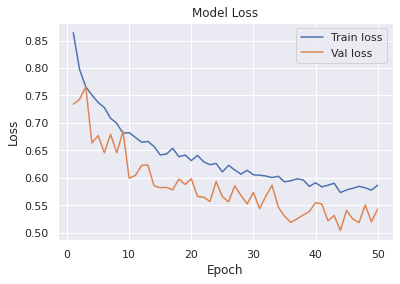

In [ ]:
model_l1.validate_test_data_accuracy(n_axes=2)

#The following 2 plots are only available if you have Keras history object
#For a pre-trained must be loaded first
model_l1.plot_accuracy_model(categorical=True)
model_l1.plot_loss_model()

######Evaluate a trajectory with the network

In [ ]:
#Please check network and trajectory length and time are correct!
track_length = 25
track_time = 0.5
n_axes = 2


# Classify fBm simulated track with the network
print("Simulating fBm trajectory...")
physical_model = FBM.create_random()
x_noisy, y_noisy, x, y, t = physical_model.simulate_track(track_length, track_time)
print('Hurst Exponent:{:.2}'.format(physical_model.hurst_exp))
track = SimulatedTrack(track_length=track_length, track_time=track_time,
                       n_axes=n_axes, model_type=physical_model.__class__.__name__)
track.set_axes_data([x_noisy, y_noisy])
track.set_time_axis(t)

classification_result = model_l1.evaluate_track_input(track=track)

print('\nClassified by the network as:{}'.format(model_l1.output_net_to_labels(classification_result)))

Simulating fBm trajectory...
Hurst Exponent:0.58

Classified by the network as:fBm


In [ ]:
# Classify CTRW simulated track with the network
print("Simulating CTRW trajectory...")
physical_model = CTRW.create_random()
x_noisy, y_noisy, x, y, t = physical_model.simulate_track(track_length, track_time)

track = SimulatedTrack(track_length=track_length, track_time=track_time,
                       n_axes=n_axes, model_type=physical_model.__class__.__name__)
track.set_axes_data([x_noisy, y_noisy])
track.set_time_axis(t)

classification_result = model_l1.evaluate_track_input(track=track)

print('\nClassified by the network as:{}'.format(model_l1.output_net_to_labels(classification_result)))


Simulating CTRW trajectory...

Classified by the network as:CTRW


In [ ]:
# Classify Two-State track with the network
print("Simulating Two-State Diffusion trajectory...")
physical_model = TwoStateObstructedDiffusion.create_random()
x_noisy, y_noisy, x, y, t, state, switching = physical_model.simulate_track(track_length, track_time)

track = SimulatedTrack(track_length=track_length, track_time=track_time,
                       n_axes=n_axes, model_type=physical_model.__class__.__name__)
track.set_axes_data([x_noisy, y_noisy])
track.set_time_axis(t)

classification_result = model_l1.evaluate_track_input(track=track)

print('\nClassified by the network as: {}'.format(model_l1.output_net_to_labels(classification_result)))

Simulating Two-State Diffusion trajectory...

Classified by the network as: 2-State-OD


---
## fBm Classification Network 
##### Output Categories  
* Subdiffusive 
* Brownian
* Superdiffusive

######Network implementation

In [10]:
class L2NetworkModel(NetworkModel):
    output_categories = 3
    output_categories_labels = ["Subdiffusive", "Brownian", "Superdiffusive"]
    model_name = 'L2 Network'

    def train_network(self, batch_size):
        initializer = 'he_normal'
        filters_size = 32
        x1_kernel_size = 4
        x2_kernel_size = 2
        x3_kernel_size = 3
        x4_kernel_size = 10
        x5_kernel_size = 6
        x6_kernel_size = 20

        inputs = Input(shape=(self.track_length - 1, 1))

        x1 = Conv1D(filters=filters_size, kernel_size=x1_kernel_size, padding='causal', activation='relu',
                    kernel_initializer=initializer)(inputs)
        x1 = BatchNormalization()(x1)
        x1 = Conv1D(filters=filters_size, kernel_size=x1_kernel_size, dilation_rate=2, padding='causal',
                    activation='relu',
                    kernel_initializer=initializer)(x1)
        x1 = BatchNormalization()(x1)
        x1 = Conv1D(filters=filters_size, kernel_size=x1_kernel_size, dilation_rate=4, padding='causal',
                    activation='relu',
                    kernel_initializer=initializer)(x1)
        x1 = BatchNormalization()(x1)
        x1 = GlobalMaxPooling1D()(x1)

        x2 = Conv1D(filters=filters_size, kernel_size=x2_kernel_size, padding='causal', activation='relu',
                    kernel_initializer=initializer)(inputs)
        x2 = BatchNormalization()(x2)
        x2 = Conv1D(filters=filters_size, kernel_size=x2_kernel_size, dilation_rate=2, padding='causal',
                    activation='relu',
                    kernel_initializer=initializer)(x2)
        x2 = BatchNormalization()(x2)
        x2 = Conv1D(filters=filters_size, kernel_size=x2_kernel_size, dilation_rate=4, padding='causal',
                    activation='relu',
                    kernel_initializer=initializer)(x2)
        x2 = BatchNormalization()(x2)
        x2 = GlobalMaxPooling1D()(x2)

        x3 = Conv1D(filters=filters_size, kernel_size=x3_kernel_size, padding='causal', activation='relu',
                    kernel_initializer=initializer)(inputs)
        x3 = BatchNormalization()(x3)
        x3 = Conv1D(filters=filters_size, kernel_size=x3_kernel_size, dilation_rate=2, padding='causal',
                    activation='relu',
                    kernel_initializer=initializer)(x3)
        x3 = BatchNormalization()(x3)
        x3 = Conv1D(filters=filters_size, kernel_size=x3_kernel_size, dilation_rate=4, padding='causal',
                    activation='relu',
                    kernel_initializer=initializer)(x3)
        x3 = BatchNormalization()(x3)
        x3 = GlobalMaxPooling1D()(x3)

        x4 = Conv1D(filters=filters_size, kernel_size=x4_kernel_size, padding='causal', activation='relu',
                    kernel_initializer=initializer)(inputs)
        x4 = BatchNormalization()(x4)
        x4 = Conv1D(filters=filters_size, kernel_size=x4_kernel_size, dilation_rate=4, padding='causal',
                    activation='relu',
                    kernel_initializer=initializer)(x4)
        x4 = BatchNormalization()(x4)
        x4 = Conv1D(filters=filters_size, kernel_size=x4_kernel_size, dilation_rate=8, padding='causal',
                    activation='relu',
                    kernel_initializer=initializer)(x4)
        x4 = BatchNormalization()(x4)
        x4 = GlobalMaxPooling1D()(x4)

        x5 = Conv1D(filters=filters_size, kernel_size=x5_kernel_size, padding='causal', activation='relu',
                    kernel_initializer=initializer)(inputs)
        x5 = BatchNormalization()(x5)
        x5 = Conv1D(filters=filters_size, kernel_size=x5_kernel_size, dilation_rate=2, padding='causal',
                    activation='relu',
                    kernel_initializer=initializer)(x5)
        x5 = BatchNormalization()(x5)
        x5 = Conv1D(filters=filters_size, kernel_size=x5_kernel_size, dilation_rate=4, padding='causal',
                    activation='relu',
                    kernel_initializer=initializer)(x5)
        x5 = BatchNormalization()(x5)
        x5 = GlobalMaxPooling1D()(x5)

        x6 = Conv1D(filters=filters_size, kernel_size=x6_kernel_size, padding='same', activation='relu',
                    kernel_initializer=initializer)(inputs)
        x6 = BatchNormalization()(x6)
        x6 = GlobalMaxPooling1D()(x6)

        x_concat = concatenate(inputs=[x1, x2, x3, x4, x5, x6])
        dense_1 = Dense(units=615, activation='relu')(x_concat)
        dense_2 = Dense(units=150, activation='relu')(dense_1)
        output_network = Dense(units=self.output_categories, activation='softmax')(dense_2)
        l2_keras_model = Model(inputs=inputs, outputs=output_network)

        optimizer = Adam(lr=1e-5)
        l2_keras_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        l2_keras_model.summary()

        callbacks = [ModelCheckpoint(filepath="models/{}.h5".format(self.id),
                                     monitor='val_loss',
                                     verbose=1,
                                     save_best_only=True)]

        history_training = l2_keras_model.fit(
            x=generator_second_layer(batch_size=batch_size, track_length=self.track_length, track_time=self.track_time),
            steps_per_epoch=2400,
            epochs=50,
            callbacks=callbacks,
            validation_data=generator_second_layer(batch_size=batch_size, track_length=self.track_length,
                                                   track_time=self.track_time),
            validation_steps=200)
        self.keras_model = l2_keras_model
        self.convert_history_to_db_format(history_training)

    def evaluate_track_input(self, track):
        assert (track.track_length == self.track_length), "Invalid input track length"

        model_predictions = np.zeros(shape=self.output_categories)

        axis_data_diff = np.zeros(shape=[1, self.track_length - 1, track.n_axes])
        for i in range(track.n_axes):
            axis_data_diff[0, :, i] = axis_adaptation_to_net(axis_data=track.axes_data[str(i)],
                                                             track_length=self.track_length)

        for axis in range(track.n_axes):
            input_net = np.zeros([1, self.track_length - 1, 1])
            input_net[0, :, 0] = axis_data_diff[0, :, axis]
            model_predictions = (self.keras_model.predict(input_net)[0, :]) + model_predictions
        mean_prediction = np.argmax(model_predictions / track.n_axes)
        return mean_prediction

    def validate_test_data_accuracy(self, n_axes, normalized=True):
        test_batch_size = 100
        ground_truth = np.zeros(shape=test_batch_size)
        predicted_value = np.zeros(shape=test_batch_size)
        for i in range(test_batch_size):
            ground_truth[i] = np.random.choice([0, 1, 2])
            if ground_truth[i] == 0:
                physical_model = FBM.create_random_subdiffusive()
            elif ground_truth[i] == 1:
                physical_model = FBM.create_random_brownian()
            else:
                physical_model = FBM.create_random_superdiffusive()

            x_noisy, y_noisy, x, y, t = physical_model.simulate_track(self.track_length, self.track_time)
            track = SimulatedTrack(track_length=self.track_length, track_time=self.track_time,
                                   n_axes=n_axes, model_type=physical_model.__class__.__name__)
            track.set_axes_data([x_noisy, y_noisy])
            track.set_time_axis(t)

            predicted_value[i] = self.evaluate_track_input(track=track)

        plot_confusion_matrix_for_layer(layer_name=self.model_name,
                                        ground_truth=ground_truth,
                                        predicted_value=predicted_value,
                                        labels=self.output_categories_labels,
                                        normalized=normalized)

    def output_net_to_labels(self, output_net):
        return self.output_categories_labels[output_net]


######Network training

In [ ]:
track_length = 25
track_time = 0.5


# Train network
K.clear_session()
model_l2 = L2NetworkModel(track_length=track_length, track_time=track_time)
model_l2.train_network(batch_size=8)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 1)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 24, 32)       160         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 24, 32)       96          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 24, 32)       128         input_1[0][0]                    
_______________________________________________________________________________________

######Load a pre-trained model

In [ ]:
#Run this cell to upload the model, then add the filename to the following cell
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

KeyboardInterrupt: ignored

In [ ]:
pre_trained_model_l2 = L2NetworkModel()
pre_trained_model_l2.model_file = '' # Here replace with the filename!
pre_trained_model_l2.load_model_from_file()
model_l2 = pre_trained_model_l2

######Network accuracy

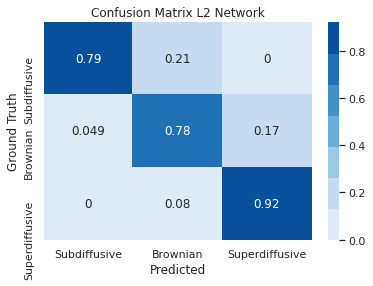

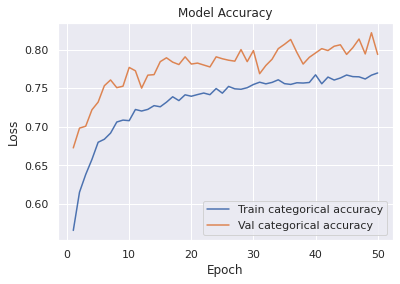

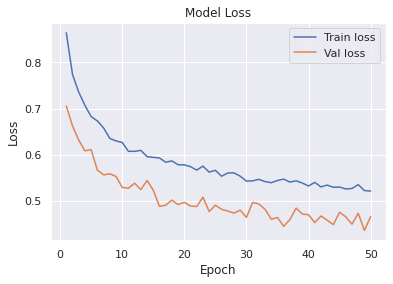

In [ ]:
model_l2.validate_test_data_accuracy(n_axes=2)

#The following 2 plots are only available if you have Keras history object
#For a pre-trained must be loaded first
model_l2.plot_accuracy_model(categorical=True)
model_l2.plot_loss_model()

######Evaluate a trajectory with the network

In [ ]:
#Please check network and trajectory length and time are correct!
track_length = 25
track_time = 0.5
n_axes = 2


# Classify fBm simulated track with the network
print("Simulating fBm subdiffusive trajectory...")
physical_model = FBM.create_random_subdiffusive()
x_noisy, y_noisy, x, y, t = physical_model.simulate_track(track_length, track_time)
print('Hurst Exponent:{:.2}'.format(physical_model.hurst_exp))
track = SimulatedTrack(track_length=track_length, track_time=track_time,
                       n_axes=n_axes, model_type=physical_model.__class__.__name__)
track.set_axes_data([x_noisy, y_noisy])
track.set_time_axis(t)

classification_result = model_l2.evaluate_track_input(track=track)

print('\nClassified by the network as:{}'.format(model_l2.output_net_to_labels(classification_result)))

Simulating fBm subdiffusive trajectory...
Hurst Exponent:0.27

Classified by the network as:Subdiffusive


In [ ]:
# Classify fBm simulated track with the network
print("Simulating fBm brownian trajectory...")
physical_model = FBM.create_random_brownian()
x_noisy, y_noisy, x, y, t = physical_model.simulate_track(track_length, track_time)
print('Hurst Exponent:{:.2}'.format(physical_model.hurst_exp))
track = SimulatedTrack(track_length=track_length, track_time=track_time,
                       n_axes=n_axes, model_type=physical_model.__class__.__name__)
track.set_axes_data([x_noisy, y_noisy])
track.set_time_axis(t)

classification_result = model_l2.evaluate_track_input(track=track)

print('\nClassified by the network as:{}'.format(model_l2.output_net_to_labels(classification_result)))

Simulating fBm brownian trajectory...
Hurst Exponent:0.44

Classified by the network as:Brownian


In [ ]:
# Classify fBm simulated track with the network
print("Simulating fBm superdiffusive trajectory...")
physical_model = FBM.create_random_superdiffusive()
x_noisy, y_noisy, x, y, t = physical_model.simulate_track(track_length, track_time)
print('Hurst Exponent:{:.2}'.format(physical_model.hurst_exp))
track = SimulatedTrack(track_length=track_length, track_time=track_time,
                       n_axes=n_axes, model_type=physical_model.__class__.__name__)
track.set_axes_data([x_noisy, y_noisy])
track.set_time_axis(t)

classification_result = model_l2.evaluate_track_input(track=track)

print('\nClassified by the network as:{}'.format(model_l2.output_net_to_labels(classification_result)))

Simulating fBm superdiffusive trajectory...
Hurst Exponent:0.58

Classified by the network as:Superdiffusive


---
## Two-State Diffusion - State Detection 
###Segmentation Network


######Network implementation


In [ ]:
class StateDetectionNetworkModel(NetworkModel):
    output_categories_labels = ["State-0", "State-1"]
    model_name = 'State Detection Network'

    def train_network(self, batch_size):
        initializer = 'he_normal'
        filters_size = 32
        x1_kernel_size = 4
        x2_kernel_size = 2
        x3_kernel_size = 3
        x4_kernel_size = 10
        x5_kernel_size = 20

        inputs = Input(shape=(self.track_length, 1))

        x1 = Conv1D(filters=filters_size, kernel_size=x1_kernel_size, padding='causal', activation='relu',
                    kernel_initializer=initializer)(inputs)
        x1 = BatchNormalization()(x1)
        x1 = Conv1D(filters=filters_size, kernel_size=x1_kernel_size, dilation_rate=2, padding='causal',
                    activation='relu',
                    kernel_initializer=initializer)(x1)
        x1 = BatchNormalization()(x1)
        x1 = Conv1D(filters=filters_size, kernel_size=x1_kernel_size, dilation_rate=4, padding='causal',
                    activation='relu',
                    kernel_initializer=initializer)(x1)
        x1 = BatchNormalization()(x1)
        x1 = GlobalAveragePooling1D()(x1)

        x2 = Conv1D(filters=filters_size, kernel_size=x2_kernel_size, padding='causal', activation='relu',
                    kernel_initializer=initializer)(inputs)
        x2 = BatchNormalization()(x2)
        x2 = Conv1D(filters=filters_size, kernel_size=x2_kernel_size, dilation_rate=2, padding='causal',
                    activation='relu',
                    kernel_initializer=initializer)(x2)
        x2 = BatchNormalization()(x2)
        x2 = Conv1D(filters=filters_size, kernel_size=x2_kernel_size, dilation_rate=4, padding='causal',
                    activation='relu',
                    kernel_initializer=initializer)(x2)
        x2 = BatchNormalization()(x2)
        x2 = GlobalAveragePooling1D()(x2)

        x3 = Conv1D(filters=filters_size, kernel_size=x3_kernel_size, padding='causal', activation='relu',
                    kernel_initializer=initializer)(inputs)
        x3 = BatchNormalization()(x3)
        x3 = Conv1D(filters=filters_size, kernel_size=x3_kernel_size, dilation_rate=2, padding='causal',
                    activation='relu',
                    kernel_initializer=initializer)(x3)
        x3 = BatchNormalization()(x3)
        x3 = Conv1D(filters=filters_size, kernel_size=x3_kernel_size, dilation_rate=4, padding='causal',
                    activation='relu',
                    kernel_initializer=initializer)(x3)
        x3 = BatchNormalization()(x3)
        x3 = GlobalAveragePooling1D()(x3)

        x4 = Conv1D(filters=filters_size, kernel_size=x4_kernel_size, padding='causal', activation='relu',
                    kernel_initializer=initializer)(inputs)
        x4 = BatchNormalization()(x4)
        x4 = Conv1D(filters=filters_size, kernel_size=x4_kernel_size, dilation_rate=4, padding='causal',
                    activation='relu',
                    kernel_initializer=initializer)(x4)
        x4 = BatchNormalization()(x4)
        x4 = Conv1D(filters=filters_size, kernel_size=x4_kernel_size, dilation_rate=8, padding='causal',
                    activation='relu',
                    kernel_initializer=initializer)(x4)
        x4 = BatchNormalization()(x4)
        x4 = GlobalAveragePooling1D()(x4)

        x5 = Conv1D(filters=filters_size, kernel_size=x5_kernel_size, padding='same', activation='relu',
                    kernel_initializer=initializer)(inputs)
        x5 = BatchNormalization()(x5)
        x5 = GlobalAveragePooling1D()(x5)

        x_concat = concatenate(inputs=[x1, x2, x3, x4, x5])
        dense_1 = Dense(units=(self.track_length * 2), activation='relu')(x_concat)
        dense_2 = Dense(units=self.track_length, activation='relu')(dense_1)
        output_network = Dense(units=self.track_length, activation='sigmoid')(dense_2)

        state_detection_keras_model = Model(inputs=inputs, outputs=output_network)

        optimizer = Adam(lr=1e-4)
        state_detection_keras_model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
        state_detection_keras_model.summary()

        callbacks = [ModelCheckpoint(filepath="models/{}.h5".format(self.id),
                                     monitor='val_loss',
                                     verbose=1,
                                     save_best_only=True)]

        history_training = state_detection_keras_model.fit(
            x=generator_state_net(batch_size=batch_size, track_length=self.track_length, track_time=self.track_time),
            steps_per_epoch=2400,
            epochs=50,
            callbacks=callbacks,
            validation_data=generator_state_net(batch_size=batch_size, track_length=self.track_length,
                                                track_time=self.track_time),
            validation_steps=200)

        self.convert_history_to_db_format(history_training)
        self.keras_model = state_detection_keras_model

    def evaluate_track_input(self, track):
        assert track.track_length == self.track_length, "Invalid track length"

        if self.keras_model is None:
            self.load_model_from_file()

        model_predictions = np.zeros(shape=self.track_length)

        for axis in range(track.n_axes):
            input_net = np.zeros(shape=[1, self.track_length, 1])
            input_net[0, :, 0] = track.axes_data[str(axis)] - np.mean(track.axes_data[str(axis)])
            model_predictions = (self.keras_model.predict(input_net)[0, :]) + model_predictions

        mean_prediction = model_predictions / track.n_axes

        # Convert to state values
        for i in range(self.track_length):
            if mean_prediction[i] < 0.5:
                mean_prediction[i] = 0
            else:
                mean_prediction[i] = 1

        return mean_prediction

    def validate_test_data_accuracy(self, n_axes, normalized=True):
        test_batch_size = 10
        ground_truth = np.zeros(shape=(test_batch_size, self.track_length))
        predicted_value = np.zeros(shape=(test_batch_size, self.track_length))
        for i in range(test_batch_size):
            physical_model = TwoStateObstructedDiffusion.create_random()

            switching = False
            while not switching:
                x_noisy, y_noisy, x, y, t, state, switching = physical_model.simulate_track(self.track_length,
                                                                                            self.track_time)

            ground_truth[i, :] = state
            track = SimulatedTrack(track_length=self.track_length, track_time=self.track_time,
                                   n_axes=n_axes, model_type=physical_model.__class__.__name__)
            track.set_axes_data([x_noisy, y_noisy])
            track.set_time_axis(t)

            predicted_value[i, :] = self.evaluate_track_input(track=track)
        ground_truth = ground_truth.flatten()
        predicted_value = predicted_value.flatten()
        plot_confusion_matrix_for_layer(layer_name=self.model_name,
                                        ground_truth=ground_truth,
                                        predicted_value=predicted_value,
                                        labels=self.output_categories_labels,
                                        normalized=normalized)

    def convert_output_to_db(self, states_net_output):
        return states_net_output.tolist()



######Network training

In [ ]:
track_length = 25
track_time = 0.5


# Train network
K.clear_session()
model_states_net = StateDetectionNetworkModel(track_length=track_length, track_time=track_time)
model_states_net.train_network(batch_size=8)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25, 1)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 25, 32)       160         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 25, 32)       96          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 25, 32)       128         input_1[0][0]                    
_______________________________________________________________________________________

######Load a pre-trained model

In [ ]:
#Run this cell to upload the model, then add the filename to the following cell
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
pre_trained_state_detection = StateDetectionNetworkModel()
pre_trained_state_detection.model_file = '' # Here replace with the filename!
pre_trained_state_detection.load_model_from_file()
model_states_net = pre_trained_state_detection

######Network accuracy

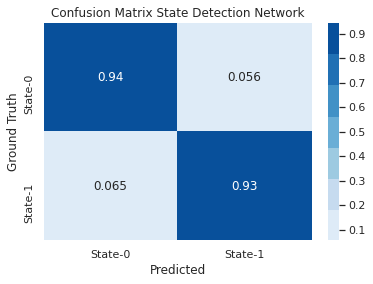

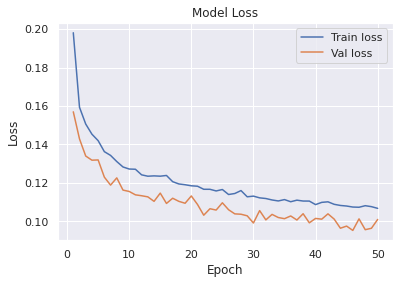

In [ ]:
model_states_net.validate_test_data_accuracy(n_axes=2)

#The following 2 plots are only available if you have Keras history object
#For a pre-trained must be loaded first
model_states_net.plot_loss_model()

######Evaluate a trajectory with the network

In [ ]:
#Please check network and trajectory length and time are correct!
track_length = 25
track_time = 0.5
n_axes = 2


# Classify Two-State track with the network
print("Simulating Two-State Diffusion trajectory...")
physical_model = TwoStateObstructedDiffusion.create_random()
x_noisy, y_noisy, x, y, t, state, switching = physical_model.simulate_track(track_length, track_time)

track = SimulatedTrack(track_length=track_length, track_time=track_time,
                       n_axes=n_axes, model_type=physical_model.__class__.__name__)
track.set_axes_data([x_noisy, y_noisy])
track.set_time_axis(t)

predicted_states = model_states_net.evaluate_track_input(track=track)

print(state)
print(predicted_states)


Simulating Two-State Diffusion trajectory...
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1.]


##Hurst Exponent Network

######Network implementation

In [11]:
class HurstExponentNetworkModel(NetworkModel):
    fbm_type = StringField(choices=["Subdiffusive", "Brownian" , "Superdiffusive"], required=True)
    model_name = "Hurst Exponent Network"

    def train_network(self, batch_size):
        inputs = Input(shape=(2, self.track_length))
        x = LSTM(units=64, return_sequences=True, input_shape=(2, self.track_length))(inputs)
        x = LSTM(units=16)(x)
        x = Dense(units=128, activation='selu')(x)
        output_network = Dense(units=1, activation='sigmoid')(x)

        hurst_exp_keras_model = Model(inputs=inputs, outputs=output_network)

        optimizer = Adam(lr=1e-4)
        hurst_exp_keras_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        hurst_exp_keras_model.summary()

        callbacks = [EarlyStopping(monitor='val_loss',
                                   patience=10,
                                   verbose=1,
                                   min_delta=1e-4),
                     ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       patience=4,
                                       verbose=1,
                                       min_lr=1e-10),
                     ModelCheckpoint(filepath="models/{}.h5".format(self.id),
                                     monitor='val_loss',
                                     verbose=1,
                                     save_best_only=True)]

        history_training = hurst_exp_keras_model.fit(
            x=generator_hurst_exp_network(batch_size=batch_size, track_length=self.track_length,
                                                 track_time=self.track_time, fbm_type=self.fbm_type),
            steps_per_epoch=500,
            epochs=20,
            callbacks=callbacks,
            validation_data=generator_hurst_exp_network(batch_size=batch_size, track_length=self.track_length,
                                                               track_time=self.track_time, fbm_type=self.fbm_type),
            validation_steps=50)

        self.convert_history_to_db_format(history_training)
        self.keras_model = hurst_exp_keras_model

    def evaluate_track_input(self, track):
        assert (track.track_length == self.track_length), "Invalid track length"
        prediction = np.zeros(shape=track.n_axes)
        out = np.zeros(shape=(1, 2, self.track_length))

        for i in range(track.n_axes):
            zero_mean_x = track.axes_data[str(i)] - np.mean(track.axes_data[str(i)])
            zero_mean_x = zero_mean_x / np.std(zero_mean_x)
            out[0, 0, :] = zero_mean_x
            out[0, 1, :] = np.linspace(0, 1, self.track_length)
            prediction[i] = self.keras_model.predict(out)[0, 0]

        return np.mean(prediction)

    def validate_test_data_mse(self, n_axes):
        test_batch_size = 100
        mse = np.zeros(shape=test_batch_size)

        for i in range(test_batch_size):
            if self.fbm_type == "Subdiffusive":
                model_sample = FBM.create_random_subdiffusive()
            elif self.fbm_type == 'Brownian':
                model_sample = FBM.create_random_brownian()
            else:
                model_sample = FBM.create_random_superdiffusive()

            x_noisy, y_noisy, x, y, t = model_sample.simulate_track(track_length=self.track_length,
                                                                    track_time=self.track_time)
            ground_truth = model_sample.hurst_exp
            noisy_data = [x_noisy, y_noisy]
            track = SimulatedTrack(track_length=self.track_length, track_time=self.track_time,
                                   n_axes=n_axes, model_type=model_sample.__class__.__name__)
            track.set_axes_data(axes_data=noisy_data)
            track.set_time_axis(time_axis_data=t)
            prediction = self.evaluate_track_input(track)
            mse[i] = mean_squared_error([ground_truth], [prediction])
            

        return np.mean(mse)


######Network training

In [ ]:
track_length = 25
track_time = 0.5
fbm_type = "Subdiffusive"  # Options: ["Subdiffusive", "Brownian", "Superdiffusive"]

# Train network
K.clear_session()
model_hurst_net = HurstExponentNetworkModel(track_length=track_length,
                                            track_time=track_time,
                                            fbm_type=fbm_type)
model_hurst_net.train_network(batch_size=64)

######Load a pre-trained model

In [ ]:
#Run this cell to upload the model, then add the filename to the following cell
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
pre_trained_hurst_net = HurstExponentNetworkModel()
pre_trained_hurst_net.model_file = '' # Here replace with the filename!
pre_trained_hurst_net.load_model_from_file()
model_hurst_net = pre_trained_hurst_net

######Network accuracy

Simulated validation set MSE:0.007196


Training MSE:


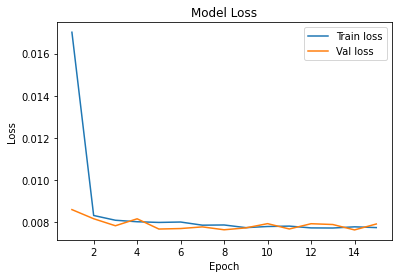

In [14]:
print("Simulated validation set MSE:{:.4}".format(model_hurst_net.validate_test_data_mse(n_axes=2)))

print("\n\nTraining MSE:")
model_hurst_net.plot_loss_model()

######Evaluate a trajectory with the network

In [29]:
#Please check network and trajectory length and time are correct!
track_length = 25
track_time = 0.5
n_axes = 2

# Classify fBm simulated track with the network
## Check fbm_type ALWAYS!



physical_model = FBM.create_random_subdiffusive()
#physical_model = FBM.create_random_brownian()
#physical_model = FBM.create_random_superdiffusive()

print("Simulating fBm type:{} trajectory...\n\n".format(physical_model.get_diffusion_type()))

x_noisy, y_noisy, x, y, t = physical_model.simulate_track(track_length, track_time)
print('Hurst Exponent:{:.3}'.format(physical_model.hurst_exp))
track = SimulatedTrack(track_length=track_length, track_time=track_time,
                       n_axes=n_axes, model_type=physical_model.__class__.__name__)
track.set_axes_data([x_noisy, y_noisy])
track.set_time_axis(t)

predicted_hurst_exp = model_hurst_net.evaluate_track_input(track)
print("\nPredicted hurst exponent:{:.3}".format(predicted_hurst_exp))

Simulating fBm type:Subdiffusive trajectory...


Hurst Exponent:0.176

Predicted hurst exponent:0.258


##Diffusion Coefficient Network

######Network implementation

In [11]:
class DiffusionCoefficientNetworkModel(NetworkModel):
    diffusion_model_range = StringField(choices=["2-State-OD", "Brownian"])

    def train_network(self, batch_size):
        initializer = 'he_normal'
        filters_size = 32
        x_kernel_size = 2

        inputs = Input(shape=(2, 1))

        x = Conv1D(filters=filters_size, kernel_size=x_kernel_size, padding='same', activation='relu',
                   kernel_initializer=initializer)(inputs)
        x = BatchNormalization()(x)
        x = GlobalMaxPooling1D()(x)

        dense_1 = Dense(units=512, activation='relu')(x)
        dense_2 = Dense(units=256, activation='relu')(dense_1)
        output_network = Dense(units=1, activation='sigmoid')(dense_2)
        diffusion_coefficient_keras_model = Model(inputs=inputs, outputs=output_network)

        optimizer = Adam(lr=1e-3)
        diffusion_coefficient_keras_model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
        diffusion_coefficient_keras_model.summary()

        callbacks = [ModelCheckpoint(filepath="models/{}.h5".format(self.id),
                                     monitor='val_loss',
                                     save_best_only=True,
                                     verbose=1)]

        history_training = diffusion_coefficient_keras_model.fit(
            x=generator_diffusion_coefficient_network(batch_size,
                                                      self.track_length,
                                                      self.track_time,
                                                      self.diffusion_model_range),
            steps_per_epoch=2400,
            epochs=10,
            callbacks=callbacks,
            validation_data=generator_diffusion_coefficient_network(batch_size,
                                                                    self.track_length,
                                                                    self.track_time,
                                                                    self.diffusion_model_range),
            validation_steps=200)
        self.convert_history_to_db_format(history_training)
        self.keras_model = diffusion_coefficient_keras_model

    def evaluate_track_input(self, track):
        assert track.track_length == self.track_length, "Invalid track length"
        prediction = np.zeros(shape=track.n_axes)
        out = np.zeros(shape=(1, 2, 1))

        axes_data = track.axes_data

        for axis in range(track.n_axes):
            d = np.diff(axes_data[str(axis)], axis=0)
            m = np.mean(np.abs(d), axis=0)
            s = np.std(d, axis=0)
            out[0, :, 0] = [m, s]
            prediction[axis] = self.keras_model.predict(out[:, :, :])
            
        if self.diffusion_model_range == "2-State-OD":
            mean_prediction = TwoStateObstructedDiffusion.denormalize_d_coefficient_to_net(
                output_coefficient_net=np.mean(prediction))
        else:
            mean_prediction = Brownian.denormalize_d_coefficient_to_net(
                output_coefficient_net=np.mean(prediction))

        return mean_prediction

    def validate_test_data_mse(self, n_axes, test_batch_size=100):
        mse_avg = np.zeros(shape=test_batch_size)
        for i in range(test_batch_size):

            if self.diffusion_model_range == "2-State-OD":
                model = TwoStateObstructedDiffusion.create_random()

                x_noisy, y_noisy, x, y, t = model.simulate_track_only_state0(track_length=self.track_length,
                                                                             track_time=self.track_time)
                ground_truth = model.get_d_state0()

            else:
                model = Brownian.create_random()
                x_noisy, y_noisy, x, y, t = model.simulate_track(track_length=self.track_length,
                                                                 track_time=self.track_time)
                ground_truth = model.get_d_coefficient()

            noisy_data = [x_noisy, y_noisy]
            track = SimulatedTrack(track_length=self.track_length, track_time=self.track_time,
                                   n_axes=n_axes, model_type=model.__class__.__name__)
            track.set_axes_data(axes_data=noisy_data)
            track.set_time_axis(time_axis_data=t)
            predicted_coefficient = self.evaluate_track_input(track)
            mse_avg[i] = mean_squared_error(y_true=[ground_truth], y_pred=[predicted_coefficient])

        return np.mean(mse_avg)

######Network training

In [12]:
track_length = 25
track_time = 0.8
diffusion_model_range = "2-State-OD" #["2-State-OD", "Brownian"]

# Train network
K.clear_session()
model_d_net = DiffusionCoefficientNetworkModel(track_length=track_length,
                                                   track_time=track_time,
                                                   diffusion_model_range=diffusion_model_range)
model_d_net.train_network(batch_size=8)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 1)]            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2, 32)             96        
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 32)             128       
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 512)               16896     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

######Load a pre-trained model

In [ ]:
#Run this cell to upload the model, then add the filename to the following cell
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
pre_trained_model_d_net =  DiffusionCoefficientNetworkModel()
pre_trained_model_d_net.model_file = '' # Here replace with the filename!
pre_trained_model_d_net.load_model_from_file()
model_d_net = pre_trained_model_d_net

######Network accuracy

Simulated validation set MSE:0.0005529


Training MSE:


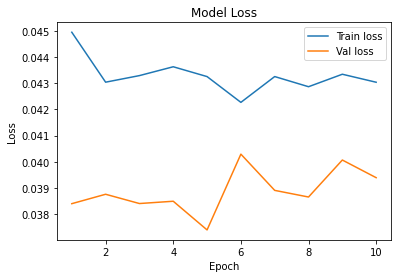

In [17]:
print("Simulated validation set MSE:{:.4}".format(model_d_net.validate_test_data_mse(n_axes=2)))

print("\n\nTraining MSE:")
model_d_net.plot_loss_model()

######Evaluate a trajectory with the network

In [35]:
#Please check network and trajectory length and time are correct!
track_length = 25
track_time = 0.8
n_axes = 2
diffusion_model_range = "2-State-OD" # ["2-State-OD", "Brownian"]

# Classify simulated track with the network

if diffusion_model_range == "Brownian":
    physical_model = Brownian.create_random()
    x_noisy, y_noisy, x, y, t = physical_model.simulate_track(track_length, track_time)
    print('Diffusion coefficient:{:.3}'.format(physical_model.d_coef))
else:
    physical_model = TwoStateObstructedDiffusion.create_random()
    x_noisy, y_noisy, x, y, t = physical_model.simulate_track_only_state0(track_length, track_time)
    print('Diffusion coefficient:{:.3}'.format(physical_model.get_d_state0()))

track = SimulatedTrack(track_length=track_length, track_time=track_time,
                       n_axes=n_axes, model_type=physical_model.__class__.__name__)
track.set_axes_data([x_noisy, y_noisy])
track.set_time_axis(t)

predicted_d_value = model_d_net.evaluate_track_input(track)
print("\nPredicted diffusion coefficient:{:.3}".format(predicted_d_value))

Diffusion coefficient:0.0595

Predicted diffusion coefficient:0.0775
